<h1 style="color: blue; text-align:center">Evaluating the Role of Chunk Size in Retrieval-Augmented Generation (RAG)</h1>


<h2 style="text-align:center;color:green">Methodology<h2>

### import required libraries

In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
import requests
import matplotlib.pyplot as plt

## Select Dataset

The **"christti/squad-augmented-v2"** dataset builds on the Stanford Question Answering Dataset (SQuAD) and includes diverse, human-curated passages with associated questions and answers. It provides rich, semantically coherent contexts spanning various topics, making it ideal for tasks like question answering and retrieval-based systems.

## Why this Dataset
 + **Diverse Topics:** The dataset covers a wide range of subjects, ensuring a comprehensive and heterogeneous knowledge base.
 + **Rich Contexts:** High-quality passages are well-suited for chunking experiments without losing semantic integrity.
 + **Real-World Relevance:** Designed around real-world use cases, it aligns closely with typical RAG applications.
 + **Benchmark Quality:** Widely recognized in NLP research, it ensures credibility and comparability of results.
 + **Ease of Use:** Its structured format simplifies preprocessing and knowledge base construction.

### load the dataset

In [6]:
ds = load_dataset("christti/squad-augmented-v2")
df = pd.DataFrame(ds["train"])

In [7]:
df.shape

(169211, 5)

the dataset contains huge number of rows. for the limitation of computational power we use only first **5000** rows from the dataset.

In [8]:
df = pd.DataFrame(ds["train"][:5000])
df.head(3)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."


Each row contains  **context**, **question** and **answer**

In [9]:
contexts = df['context'].unique()

In [10]:
contexts.shape

(820,)

there are 820 different contexts

### Concatenate all the contexts to create a unified knowledge base or corpus.

In [12]:
corpus = ' '.join([context for context in contexts])

In [14]:
len(corpus)

600535

In [15]:
len(corpus.split(" "))

96449

96449 words

## Select Chunk Size

Now the corpus will be divided into different chunk size. We will consider 4 type of chunk type.
   + page
   + small 
   + medium 
   + large 

in the dataset we have seen each row has a context. so we will consider each context as a page. this is also one of the popular chunking strategy. for getting optimal chunk size for **small, medium and large** let analyse the length of each context.  

### Analyze length of contexts

In [22]:
pd.Series(df['context'].unique()).str.len().describe()

count     820.000000
mean      731.360976
std       358.499497
min       154.000000
25%       468.750000
50%       667.000000
75%       912.500000
max      3076.000000
dtype: float64

**Small Chunk:** ~250–500 characters. This covers short passages, ideally capturing documents around the 25th percentile.<br>
**Medium Chunk:** ~500–800 characters. This aligns with documents near the mean and median length.<br>
**Large Chunk:** ~800–1,200 characters or even up to 1,500 characters. This range would cover longer documents that approach the 75th percentile or exceed the mean.<br>
**Set Chunk Overlaps:** Since we may need overlapping text for context (e.g., sentence continuity), we use overlaps of around 10–20% of each chunk size:<br>
**Small chunks:** ~50–100 characters overlap<br>
**Medium chunks:** ~100–150 characters overlap<br>
**Large chunks:** ~150–200 characters overlap<br>

## Store all the chunks of each chunk type in a table in Database

### create chunks for each chunk size

<code>get_chunks_by_size()</code> function is used to devide the **knowledge base or corpus** into chunks of given chunk size and  overlap.

In [ ]:
def get_chunks_by_size(chunk_size: int, overlap: int, corpus: str):
    chunk_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=overlap
    )
    return chunk_splitter.split_text(corpus)

## Table for storing chunks in DB
I have created a table in my local Database for storing all the chunks of each chunk type and their corresponding embeddings. The database table looks like, 

### Table: text_vectors

| Field      | Type                                  | Null | Key | Default | Extra          |
|------------|---------------------------------------|------|-----|---------|----------------|
| id         | int                                   | NO   | PRI | NULL    | auto_increment |
| chunk_text | text                                  | YES  |     | NULL    |                |
| chunk_type | enum('PAGE','SMALL','MEDIUM','LARGE') | NO   |     | NULL    |                |
| embedding  | blob                                  | YES  |     | NULL    |                |


## Calculate embeddings for each chunk
After getting chunks from <code>get_chunks_by_size()</code> function, we can calculate their embeddings. But before calculating embeddings one of the most important step is **Text Preprocessing**. The following steps are included in **Text Preprocessing**.

### Text Preprocessing

In [25]:
def text_preprocessing(text):
    """
    Apply all preprocessing functions to the input text.
    """
    # Step 1: Remove HTML tags
    text = removeHTMLTags(text)
    
    # Step 2: Remove URLs
    text = removeURL(text)
    
    # Step 3: Remove punctuation
    text = remove_punctuation(text)
    
    # Step 4: Remove stopwords
    text = remove_stopwords(text)
    
    # Step 5: stemming
    text = stem_word(text)
    
    # Step 6: lemmatization
    text = lemmatize_text(text)
    return text

After text preprocessing the chunks are ready to be converted into vector. <code>get_embeddings()</code> function is used to calculate embeddings for each chunk.

In [ ]:
def get_embeddings(text):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    vector = model.encode(text)
    pickled_vector = pickle.dumps(vector)
    return pickled_vector

After calculating embeddings all the chunks are stored in <code>text_vectors</code> table in local database.

## Analyze Stored chunks in Database

### Get all the chunks from the Database and convert them into pandas Dataframe

In [32]:
url = "http://172.24.0.127:8080/app/get/chunks"
response = requests.get(url)
response.raise_for_status() 
data = response.json() 
chunks = pd.DataFrame(data) 


In [33]:
chunks.head(3)

,chunk_text,chunk_type,embedding,id
0,"Architecturally, the school has a Catholic cha...",PAGE,8004958c060000000000008c156e756d70792e636f7265...,1
1,"As at most other universities, Notre Dame's st...",PAGE,8004958c060000000000008c156e756d70792e636f7265...,2
2,The university is the major seat of the Congre...,PAGE,8004958c060000000000008c156e756d70792e636f7265...,3


In [34]:
chunks.shape

(3705, 4)

### Analyze chunk types

In [44]:
chunk_type=chunks.groupby("chunk_type")['chunk_type'].count()
chunk_type

chunk_type
LARGE      589
MEDIUM     883
PAGE       820
SMALL     1413
Name: chunk_type, dtype: int64

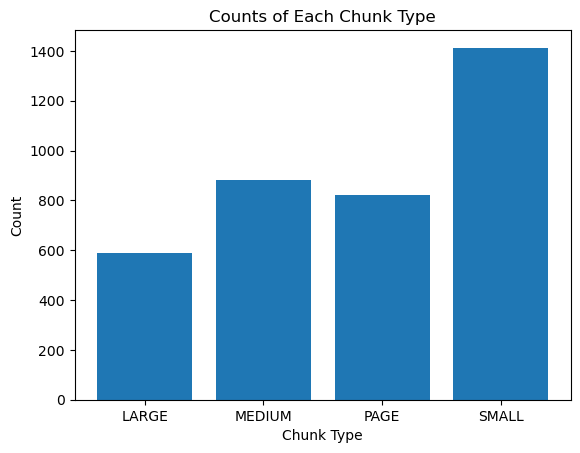

In [43]:
plt.bar(chunk_type.index, chunk_type.values)
plt.xlabel("Chunk Type")
plt.ylabel("Count")
plt.title("Counts of Each Chunk Type")
plt.show()


## Get similar chunks from DB for a given query.
Now we have stored all the chunks in our db. If we have an user query, we can get the most relevant chunks to answer this query. For this we also need to perform the above steps, which we did for each chunks. 
  + preprocess the query 
  + calculate embeddings of the query 

After calculating the embeddings of the user query, we can perform a **Vector Search** to find the most relevant chunks. for this the function <code>get_context_by_chunk_type()</code> is used. This function performes the followin steps,
   + get all the chunks from the database 
   + convert the user query into embeddings 
   + calculate **cosine similarity** of each chunk with the user query.
   + store the chunks in a list
   + sort the list based on similarity score
   + return top 3 relevant chunks as a string

In [1]:
def get_context_by_chunk_type(chunk_type, query_text):
        start_time = time.time()
        
        # get db connection
        connection = create_connection()
        cursor = connection.cursor()
        cursor.execute(
            "SELECT * FROM text_vectors WHERE chunk_type=%s", (chunk_type,)
        ) 
        
        # get all the chunks
        rows = cursor.fetchall()
        
        # convert user query into vector
        clean_query = preprocess_text(query_text.lower())
        model = SentenceTransformer("all-MiniLM-L6-v2")
        query_vector = model.encode(clean_query)
        
        # calculate cosine similarity 
        similar: list[Similar_Text] = []
        for row in rows:
            sim_score = cosine_similarity(pickle.loads(row[3]), query_vector)
            similar.append(Similar_Text(row[1], sim_score=sim_score))
            
        # sort all the chunks based on similarity score with the user query    
        similar.sort(key=lambda similar: similar.sim_score, reverse=True)
        text = "/n".join([sm.text for sm in similar[:3]])
        end_time = time.time()
        return {"retrieval_time": end_time - start_time, "text": text}

## Generate response by LLM
After getting the relevant chunks from the **Vector Database***, we can send this context + user query as a prompt to the LLM to generate a response. the function <code>chat_with_ai()</code> generate response for a given user query. Additionally, the response time is also calculated. 

In [ ]:
def chat_with_ai(user_query: str, chunk_type, ref_ans):
    # get openai key
    openai_api_key = os.environ["OPENAI_API_KEY"]  
    
    # get relevant chunks
    result = get_context_by_chunk_type(chunk_type, user_query)
    
    # format prompt 
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=result["text"], question=user_query)
    
    # generate response
    model = ChatOpenAI(openai_api_key=openai_api_key, model_name="gpt-4o")
    start_time = time.time()
    response_text = model.invoke(prompt)
    end_time = time.time()
    delta = end_time - start_time
    return {"response_time":delta,"response":response_text.content}

## Used Prompt template

In [ ]:
PROMPT_TEMPLATE = """
            Provide an answer to the question below based exclusively on the Context provided. 
            Do not include information outside of this Context in your response.


            **Context:**
            {context}

            ---------
            **Question:** {question}
 
        """

## Generate Response for 90 user Queries
for analysing the impact of chunk size on the response of LLM I have randomly choosen 90 questions from the dataset. For each question, 4 responses are generated.
 + response for page chunking
 + response for small chunking
 + response for medium chunking
 + response for large chunking

in client the function <code>chat_with_ai()</code> is used to generate a response for a user query.

In [1]:
def chat_with_ai(question, chunk_type,ref_ans):
    # Properly encode parameters separately
    question = requests.utils.quote(question)
    chunk_type = requests.utils.quote(chunk_type)

    # Construct the URL
    url = f"http://127.0.0.1:8080/app/chat/{question}/{chunk_type}/{ref_ans}"

    # Make the request
    response = requests.get(url)
    
    # Return the response as JSON
    if response.status_code == 200:
        return response
    else:
        print("Error:", response.status_code)
        return {"error": "Something went wrong"}

## Generate responses for 90 questions
I have stored all the responses in another Table in my Database. 

In [2]:
for q,ans in zip(questions,answers):
    chunk_type=['PAGE','SMALL','MEDIUM','LARGE'] 
    for c in chunk_type: 
      chat_with_ai(q,c,ans)
   

NameError: name 'questions' is not defined

### Table: evaluate_answer

| Field          | Type                                  | Null | Key | Default | Extra          |
|----------------|---------------------------------------|------|-----|---------|----------------|
| id             | int                                   | NO   | PRI | NULL    | auto_increment |
| ref_answer     | text                                  | YES  |     | NULL    |                |
| chunk_type     | enum('PAGE','SMALL','MEDIUM','LARGE') | NO   |     | NULL    |                |
| llm_response   | text                                  | YES  |     | NULL    |                |
| response_time  | double                                | YES  |     | NULL    |                |
| retrieval_time | double                                | YES  |     | NULL    |                |


## Analyze generated responses

In [4]:
url = "http://172.24.0.127:8080/app/get/responses"
response = requests.get(url)
response.raise_for_status() 
data = response.json() 
responses = pd.DataFrame(data) 

In [5]:
responses.head()

,chunk_type,id,llm_response,ref_answer,response_time,retrieval_time
0,PAGE,1,"""Formation"" was released by Beyoncé in Februar...","On February 6, 2016, one day before her Super ...",1.564220,2.501853
1,SMALL,2,"""Unknown based on the Context provided.""","On February 6, 2016, one day before her Super ...",0.875026,1.900175
2,MEDIUM,3,"""The Context provided does not specify when Be...","On February 6, 2016, one day before her Super ...",0.888419,1.369914
3,LARGE,4,"""Based on the provided Context, there is no in...","On February 6, 2016, one day before her Super ...",1.163664,1.433956
4,PAGE,5,"""'03 Bonnie & Clyde""",The music video for '03 Bonnie & Clyde' where ...,0.864547,1.388123
